In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Optimizers Definition

In [ ]:
class Gravity(tf.keras.optimizers.Optimizer):
    def __init__(self, dt, g, name="Gravity", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self.g = g
        self.dt = dt
        self.epsilon = 1e-7
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "velocity")


    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        # Compute sine and cosine based on sin(arctan(X)) and cos(arctan(x)) formula
        sine = tf.math.divide(grad, tf.math.sqrt(1+tf.math.square(grad)+self.epsilon))
        cosine = tf.math.divide(1, tf.math.sqrt(1+tf.math.square(grad)+self.epsilon))

        # Update Velocity
        current_velocity = self.get_slot(var, "velocity")
        mask = current_velocity*grad<0
        corrected_velocity = tf.where(mask, current_velocity, 0)
        updated_velocity = -self.g*(sine*cosine)*self.dt + corrected_velocity
        updated_var = updated_velocity*self.dt + var
        current_velocity.assign(updated_velocity)
        var.assign(updated_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError
    def get_config(self):
        base_config = super().get_config()
        return base_config

In [ ]:
class Gravity2(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate, beta=0.9, c=1, name="Gravity", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self.learning_rate = learning_rate
        self.beta = beta
        self.c = c
        self.epsilon = 1e-7
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "velocity")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        m = tf.reduce_max(tf.abs(grad))*self.c
        gradient_term = (grad) / (1 + (grad/(m+self.epsilon))**2)
        velocity = self.get_slot(var, "velocity")
        updated_velocity = self.beta*velocity + (1-self.beta)*gradient_term
        updated_var = var - self.learning_rate*updated_velocity
        velocity.assign(updated_velocity)
        var.assign(updated_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError
    def get_config(self):
        base_config = super().get_config()
        return base_config

In [ ]:
class Pace(tf.keras.optimizers.Optimizer):
    def __init__(self, lr, name="AdaptivePace", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self.learning_rate = lr
        self.epsilon = 1e-7
        self.pace_log = {'min':[], 'max':[], 'mean':[], 'std':[]}
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        pass

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        # dist = tfp.distributions.Normal(loc=float(tf.math.reduce_mean(grad)),
        #                         scale=float(tf.math.reduce_std(grad)),
        #                         validate_args=False, allow_nan_stats=False, name='Normal')
        # b = dist.prob(float(tf.math.reduce_std(grad)))
        # self.pace_log['min'].append(tf.reduce_min(grad).numpy())
        # self.pace_log['max'].append(tf.reduce_max(grad).numpy())
        # self.pace_log['mean'].append(tf.reduce_mean(grad).numpy())
        # self.pace_log['std'].append(tf.math.reduce_std(grad).numpy())      
        b = self.learning_rate
        a = b*abs(float(tf.math.reduce_std(grad)))
        step = -a*tf.math.tanh((b/a)*grad)
        updated_var = step + var
        var.assign(updated_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError
    def get_config(self):
        base_config = super().get_config()
        return base_config

# Models Definitions

## LeNet-5

In [ ]:
def lenet5(input_shape=(32, 32, 1), num_classes=10, activation_function='tanh', classifier_activation=None):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation=activation_function, padding='valid', input_shape=input_shape))
    model.add(tf.keras.layers.AveragePooling2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation=activation_function, padding='valid'))
    model.add(tf.keras.layers.AveragePooling2D((2, 2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(units=120, activation=activation_function))
    model.add(tf.keras.layers.Dense(units=84, activation=activation_function))
    model.add(tf.keras.layers.Dense(units=num_classes, activation=classifier_activation))
    return model


def alexnet(input_shape=(227, 227, 3), num_classes=1000, activation_function='relu', classifier_activation='softmax'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation=activation_function, padding='valid', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(units=4096, activation=activation_function))
    model.add(tf.keras.layers.Dense(units=4096, activation=activation_function))
    model.add(tf.keras.layers.Dense(units=num_classes, activation=classifier_activation))
    return model


def vgg16(input_shape=(224, 224, 3), num_classes=1000, activation_function='relu', classifier_activation='softmax', drop_out_rate=0.5):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation_function, padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(units=4096, activation=activation_function))
    model.add(tf.keras.layers.Dropout(drop_out_rate))
    model.add(tf.keras.layers.Dense(units=4096, activation=activation_function))
    model.add(tf.keras.layers.Dropout(drop_out_rate))
    model.add(tf.keras.layers.Dense(units=num_classes, activation=classifier_activation))
    return model

def custom_vgg16(input_shape=(32, 32, 3), num_classes=10, activation_function='relu', classifier_activation=None, drop_out_rate=0.5):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation_function, padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(units=4096, activation=activation_function))
    model.add(tf.keras.layers.Dropout(drop_out_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units=4096, activation=activation_function))
    model.add(tf.keras.layers.Dropout(drop_out_rate))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units=num_classes, activation=classifier_activation))
    return model

# MNIST Dataset Test

In [ ]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')

X_train, X_test = X_train / 255.0, X_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPool2D((2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

cost_func = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,)
pace_opt = Pace(lr=0.001)
gravity_opt = Gravity2(learning_rate=0.1, c=1)
model.compile(optimizer=gravity_opt, loss=cost_func, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  min_delta=0,
                                                  patience=20,
                                                  verbose=1,
                                                  mode="auto",
                                                  baseline=None,
                                                  restore_best_weights=True)
my_callbacks = [early_stopping]
model.fit(X_train, y_train, epochs=500, batch_size=256, validation_data=(X_test, y_test))


In [ ]:
model.evaluate(X_test,  y_test, verbose=1)

# CIFAR 10

In [ ]:
(input_train, target_train), (input_test, target_test) = tf.keras.datasets.cifar10.load_data()
img_width, img_height, img_num_channels = 32, 32, 3
no_classes = 10
input_shape = (img_width, img_height, img_num_channels)
# print(target_train.shape)
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
cifar_model = custom_vgg16((32, 32, 3), 10, classifier_activation=None)

# Optimizers definition
pace_opt = Pace(lr=0.05)
gravity_opt = Gravity2(learning_rate=0.075, beta=0.9, c=1)
sgd_opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)


# Model configuration
optimizer = gravity_opt
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
cifar_model.compile(loss=cost_func, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
batch_size = 128
no_epochs = 100
verbosity = 1
history1 = cifar_model.fit(input_train, target_train,
                          batch_size=batch_size,
                          epochs=no_epochs,
                          verbose=verbosity,
                          validation_data=(input_test, target_test))

# No Drop Out
**Adam**: loss: 0.0757 - accuracy: 0.9737 - val_loss: 2.8531 - val_accuracy: 0.6755

**Gravity**: loss: 3.9684e-04 - accuracy: 1.0000 - val_loss: 2.7818 - val_accuracy: 0.7048

# With Drop Out 0.5
***50 Epochs***

**Adam**: loss: 0.5390 - accuracy: 0.8111 - val_loss: 0.9564 - val_accuracy: 0.7133

**Gravity**: loss: 0.5070 - accuracy: 0.8219 - val_loss: 0.9880 - val_accuracy: 0.7164

***100 Epochs***

**Adam**: loss: 0.3687 - accuracy: 0.8640 - val_loss: 1.3471 - val_accuracy: 0.7096

**Gravity**: loss: 0.3024 - accuracy: 0.8952 - val_loss: 1.1554 - val_accuracy: 0.7310

In [ ]:
# Generate generalization metrics
score = cifar_model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.9563698172569275 / Test accuracy: 0.7132999897003174


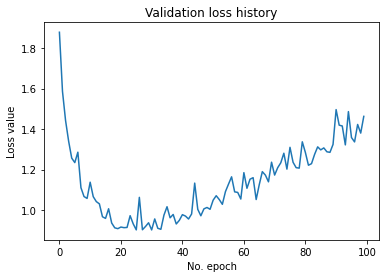

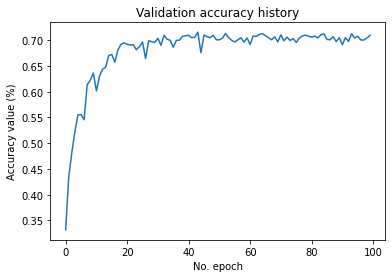

In [ ]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()